# Воронка продаж

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.
Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

В файле `logs_exp.csv` содержится лог действий и событий, которые совершают пользователи в приложении:
* __``EventName``__ — *название события*
* __``DeviceIDHash``__ — *уникальный идентификатор пользователя*
* __``EventTimestamp``__ — *время события*
* __``ExpId``__ — *номер эксперимента: __246__ и __247__ — контрольные группы, __248__ — экспериментальная группа*

## 1) Ознакомление с данными

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('logs_exp.csv', sep="\t")
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


## 2) EDA

In [3]:
df.columns = ['event', 'user_id', 'event_timestamp', 'experiment']
df['dt'] = pd.to_datetime(df['event_timestamp'], unit='s')
df.drop(['event_timestamp', 'experiment'], axis=1, inplace=True)
df.drop_duplicates(inplace=True, ignore_index=True)
df

,event,user_id,dt
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42
...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58


## 2.1) Количество событий

In [4]:
events = df.groupby('event').agg({'dt':'count', 'user_id':'nunique'}).sort_values(by='dt', ascending=False).reset_index()
events.columns = ['Событие', 'Кол-во событий', 'Кол-во пользователей']

total_users = len(df['user_id'].unique())  # Всего уникальных пользователей
events['Доля от всех пользователей'] = events['Кол-во пользователей'] / total_users

events

,Событие,Кол-во событий,Кол-во пользователей,Доля от всех пользователей
0,MainScreenAppear,119101,7439,0.985168
1,OffersScreenAppear,46808,4613,0.610912
2,CartScreenAppear,42668,3749,0.496491
3,PaymentScreenSuccessful,34118,3547,0.469739
4,Tutorial,1018,847,0.112171


Стоит обратить внимание, что событие `MainScreenAppear` (главный экран приложения) посетили не все пользователи (только в 98,5% пользователей), что может свидетельствовать о том, что в работоспособности приложения имеются недоработки.

## 2.2) Количество событий на одного пользователя

In [5]:
epu = df.groupby('user_id').agg({'event':'count'}).sort_values(by='event', ascending=False).reset_index()
epu

,user_id,event
0,6304868067479728361,2307
1,197027893265565660,1998
2,4623191541214045580,1768
3,6932517045703054087,1439
4,1754140665440434215,1221
...,...,...
7546,7399061063341528729,1
7547,2968164493349205501,1
7548,8071397669512236988,1
7549,425817683219936619,1


In [6]:
q99 = epu['event'].quantile(0.99)
print(f'99% пользователей совершают менее {q99} событий')

99% пользователей совершают менее 200.5 событий


Text(165, 2300, 'Квантиль 0.99')

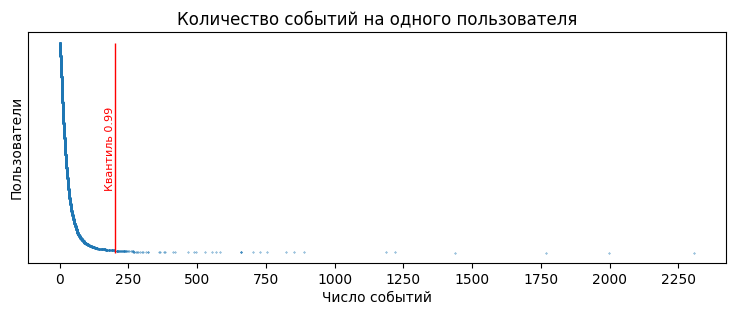

In [7]:
fig, ax = plt.subplots(figsize=(9, 3))
ax.set_title('Количество событий на одного пользователя')
ax.scatter(epu['event'], epu.index, s=0.1)
ax.set_xlabel('Число событий', labelpad=3)
ax.set_ylabel('Пользователи', labelpad=3)
ax.set_yticks([])
ax.set_xticks([i for i in range(0, 2501, 250)])
ax.vlines(q99, 0, 7550, linewidth=1, color='red')
ax.text(165, 2300, s='Квантиль 0.99', color='red', size=8, rotation='vertical')

Таким образом, 99% пользователей совершают менее 200.5 событий. Значит, все значения, которые превышают 200 событий можно считать аномальными.

## 2.3) Определение временного промежутка анализа

In [8]:
df['date'] = df['dt'].dt.date
ts = df.groupby('date').agg({'dt':'count'}).reset_index().sort_values(by='date')
ts.columns = ['date', 'N']
ts

,date,N
0,2019-07-25,9
1,2019-07-26,31
2,2019-07-27,55
3,2019-07-28,105
4,2019-07-29,184
5,2019-07-30,412
6,2019-07-31,2030
7,2019-08-01,36141
8,2019-08-02,35554
9,2019-08-03,33282


(0.0, 40000.0)

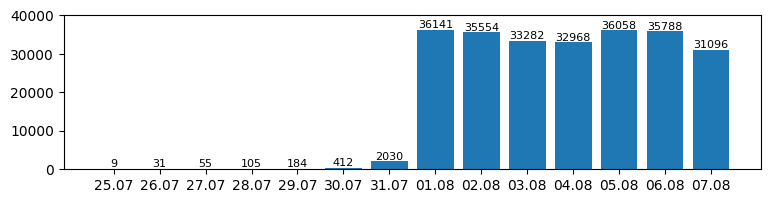

In [25]:
fig, ax = plt.subplots(figsize=(9, 2))
dates = ['25.07', '26.07', '27.07', '28.07', '29.07', '30.07', '31.07',
         '01.08', '02.08', '03.08', '04.08', '05.08', '06.08', '07.08']
b = ax.bar(dates, ts['N'])
ax.bar_label(b, ts['N'], fontsize=8)
ax.set_ylim(0, 40000)

Стоит обратить внимание, что до 1 августа событий почти не происходило.

# 3) Воронка событий

In [10]:
funnel = df.groupby('event').agg({'dt':'count', 'user_id':'nunique'}).sort_values(by='dt', ascending=False).reset_index()
funnel.columns = ['Событие', 'Кол-во событий', 'Кол-во пол-ей']

# Доля от предыдущего шага
funnel['Доля от пред. шага'] = 100
for i in range(0, 4):
    funnel.at[i+1, 'Доля от пред. шага'] = round(100-(funnel.at[i, 'Кол-во пол-ей'] - funnel.at[i+1, 'Кол-во пол-ей'])*100 / funnel.at[i, 'Кол-во пол-ей'], 0)

# Доля потерь пользователей от предыдущего шага
funnel['Потеря от пред. шага.'] = 100 - funnel['Доля от пред. шага']

# Доля от изначального
funnel['Доля от изнач.'] = 100
for i in range(0, 4):
    funnel.at[i+1, 'Доля от изнач.'] = round(100-(funnel.at[0, 'Кол-во пол-ей'] - funnel.at[i+1, 'Кол-во пол-ей'])*100 / funnel.at[0, 'Кол-во пол-ей'], 0)

funnel

,Событие,Кол-во событий,Кол-во пол-ей,Доля от пред. шага,Потеря от пред. шага.,Доля от изнач.
0,MainScreenAppear,119101,7439,100,0,100
1,OffersScreenAppear,46808,4613,62,38,62
2,CartScreenAppear,42668,3749,81,19,50
3,PaymentScreenSuccessful,34118,3547,95,5,48
4,Tutorial,1018,847,24,76,11


Обучение в воронку не входит, так как пользователь может совершать покупку и другие дествия из воронки вне зависимости от того, прошел ли он обучение.

In [11]:
funnel.drop(4, inplace=True)

In [12]:
from plotly import graph_objects as go

fig = go.Figure(go.Funnel(
    y = funnel['Событие'],
    x = funnel['Кол-во пол-ей'], 
    textinfo = "value+percent previous+percent initial"))
fig.show()

### Вывод
Таким образом, получаются следующие результаты:
* До этапа совершения покупки доходят __48%__ пользователей.
* Больше всего пользователей (__38%__) теряется после первого шага воронки `MainScreenAppear` (главный экран приложения). На остальных шагах воронки потери пользователей не такие серьёзные.
* В целом ситуация по каждой тестовой группе идентична, разница между группами составляет примерно __1-2%__.

Стоит также обратить внимание на следующие инсайты:
- Событие `MainScreenAppear` (главный экран приложения) посетили не все пользователи (только в 98,5% пользователей), что может свидетельствовать о том, что в работоспособности приложения имеются недоработки.
- До 1 августа событий почти не происходило